In [1]:
import torch
import torch.nn as nn 
import torchvision
from torchinfo import summary
from matplotlib import pyplot as plt 
from torchvision import datasets , transforms , models
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
NUM_WORKER = 4

### Create Dataset and DataLoaders

In [4]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_data_path = "Data/Flowers/train"
test_data_path = "Data/Flowers/test"
validation_data_path = "Data/Flowers/valid"

In [6]:
BATCH_SIZE = 32
train_dataset = datasets.ImageFolder(
    root = train_data_path , transform = preprocess
)
test_dataset = datasets.ImageFolder(root = test_data_path , transform = preprocess)
valid_dataset = datasets.ImageFolder(root = validation_data_path , transform = preprocess)

In [7]:
class_names = train_dataset.classes

In [8]:
# dataloader 
train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size= BATCH_SIZE, 
    num_workers = NUM_WORKER,
    pin_memory= True,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_dataset, 
    batch_size= BATCH_SIZE, 
    num_workers = NUM_WORKER,
    pin_memory= True,
    shuffle = False
)

val_loader = DataLoader(
    dataset = valid_dataset, 
    batch_size= BATCH_SIZE, 
    num_workers = NUM_WORKER,
    pin_memory= True,
    shuffle = False
)

In [9]:
# load a batch
image_batch , label_batch = next(iter(train_loader))
# take a single image from the batch 
image , label = image_batch[0] , label_batch[0]
print(image.shape , label)

torch.Size([3, 224, 224]) tensor(1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


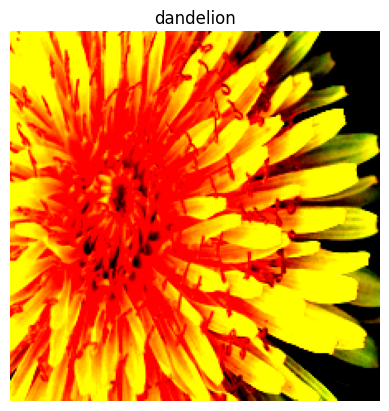

In [10]:
plt.imshow(image.permute(1 , 2 , 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

## Step-01:
---
`Task:` 
   - Turn an image into patches
   - Flatten the patch feature maps into a single dimension
   - Convert the output into desired output(Flattened 2D patch)
        - Input image shape: (224 , 224)
        - Patch size: (16 , 16) with stride = 16
        - Number of patches = 196
        - 2D shape of patches will be (196,768) convert this into 1D => (1 , 768 , 196)
    

In [11]:
class PatchEmbedding(nn.Module): 
    """ Turns a 2D input image (C , H , W) into a 1D sequence learnable embedding vector.

    Args: 
        in_channels(int): Number of color channels for the input images. Default 3(RGB).
        patch_size (int): Size of patches to convert input image into. Default 16 as ViT Paper.
        embedding_dim (int): Size of embedding to turn image into. Default 768.
    """
    def __init__(self , in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768): 
        super().__init__()
        self.patch_size = patch_size
        # create the layer to turn image into patches
        self.patcher = nn.Conv2d(
            in_channels = in_channels, 
            out_channels = embedding_dim, 
            kernel_size = patch_size, 
            stride = self.patch_size
        )
        # create a layer to flatten to patch feature map into a single dimension 
        self.flatten = nn.Flatten(start_dim = 2 , end_dim = 3) # FLatten only height and width 

    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        # Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [12]:
image.shape[-1]

224

In [13]:
# Let's test it on single image
patch_size =16

# Set seeds
def set_seeds(seed: int = 42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations
    torch.cuda.manual_seed(seed)
    
    
    
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [14]:
image.shape

torch.Size([3, 224, 224])

In [15]:
image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

### Now add the Learnable class embedding and position embeddings

In [16]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-1.1897,  0.1876,  0.0444,  ...,  0.4516, -0.9527,  0.4872],
         [-1.0488,  0.0523,  0.0617,  ...,  0.0157, -0.7412,  0.9598],
         ...,
         [-0.3587, -0.3393, -0.2742,  ..., -0.3117, -0.2105,  0.7166],
         [ 0.8114, -0.6572, -0.0363,  ..., -1.5173,  1.0272, -0.1242],
         [ 1.7703, -0.4161,  0.0923,  ..., -1.3717,  0.8075, -0.1349]]],
       grad_fn=<CatBackward0>)


In [18]:
# create the multi-head attention block 
# This class represent the Norm+MultiHeadAttention Block
class MultiheadSelfAttentionBlock(nn.Module): 
    def __init__(self , 
                 embedding_dim: int = 768 ,
                 num_heads: int = 12, 
                 attention_dropout: float = 0.0 
    ): 
        super().__init__()
        # create a layer normalization 
        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)
        # create the MultiHead attention layer 
        self.multihead_attention_layer = nn.MultiheadAttention(
            embed_dim = embedding_dim, 
            num_heads = num_heads, 
            dropout = attention_dropout, 
            batch_first = True
        )

    def forward(self , x): 
        x = self.layer_norm(x)
        attention_output , _ = self.multihead_attention_layer(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attention_output

In [19]:
# create the MLP block 
# This class represent Norm + MLP Block 
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x    

### create the ViT encoder 

In [23]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA(Multi-head self Attention) block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attention_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [24]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)                    [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention_layer)        --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                                [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                      [1, 197, 768]        [1, 197, 7

In [25]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int = 224, # Training resolution from Table 3 in ViT paper
                 in_channels:int = 3, # Number of channels in input image
                 patch_size:int = 16, # Patch size
                 num_transformer_layers:int = 12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int = 768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int = 3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int = 12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float = 0, # Dropout for attention projection
                 mlp_dropout:float = 0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float = 0.1, # Dropout for patch and position embeddings
                 num_classes:int = 1000): # Default for ImageNet but can customize this
        
        super().__init__() 
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data = torch.randn(1, 1, embedding_dim),
            requires_grad = True
        )
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data = torch.randn(1, self.num_patches+1, embedding_dim),
            requires_grad = True
        )
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoderBlock(
                embedding_dim = embedding_dim,
                num_heads = num_heads,
                mlp_size = mlp_size,
                mlp_dropout = mlp_dropout
            ) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape = embedding_dim),
            nn.Linear(in_features = embedding_dim, 
                      out_features = num_classes)
        )
    
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [26]:
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [27]:
vit = ViT(num_classes=len(class_names)).to(device)

In [28]:
optimizer = torch.optim.AdamW(
    vit.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)
criterion = torch.nn.CrossEntropyLoss()

In [29]:
EPOCHS = 10
for epoch in range(EPOCHS):
    vit.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(device)
        labels = labels.to(device)

        # forward
        outputs = vit(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # metrics
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    
    vit.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = vit(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

   
    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

Epoch 1/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.78it/s]


Epoch [1/10] | Train Loss: 1.4899, Train Acc: 0.4015 | Val Loss: 1.1155, Val Acc: 0.5585


Epoch 2/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.77it/s]


Epoch [2/10] | Train Loss: 1.0801, Train Acc: 0.5673 | Val Loss: 1.0811, Val Acc: 0.5562


Epoch 3/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.76it/s]


Epoch [3/10] | Train Loss: 1.0291, Train Acc: 0.5938 | Val Loss: 1.0242, Val Acc: 0.5991


Epoch 4/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.74it/s]


Epoch [4/10] | Train Loss: 0.9531, Train Acc: 0.6164 | Val Loss: 1.0445, Val Acc: 0.5863


Epoch 5/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.79it/s]


Epoch [5/10] | Train Loss: 0.9621, Train Acc: 0.6187 | Val Loss: 1.1168, Val Acc: 0.5504


Epoch 6/10 [Train]:   0%|                                                                       | 0/95 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [11]:
image.shape

torch.Size([3, 224, 224])